In [5]:
import numpy as np 
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
from time import time


def simulate(ref, cat_states, cat_controls, t, step_horizon, N, reference, image_path, save=False):
    def create_triangle(state=[0,0,0], h=40, w=20, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [cos(th), -sin(th)],
            [sin(th),  cos(th)]
        ])

        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]

    def init():
        # return path, horizon, current_state, target_state,
        return path, current_state, target_state,

    def animate(i):
        # get variables
        x = cat_states[0, 0, i]
        y = cat_states[1, 0, i]
        th = cat_states[2, 0, i]

        # update path
        if i == 0:
            path.set_data(np.array([]), np.array([]))
        x_new = np.hstack((path.get_xdata(), x))
        y_new = np.hstack((path.get_ydata(), y))
        path.set_data(x_new, y_new)

        # update horizon
        x_new = cat_states[0, :, i]
        y_new = cat_states[1, :, i]
        # horizon.set_data(x_new, y_new)

        # update current_state
        current_state.set_xy(create_triangle([x, y, th], update=True))

        # update target_state
        # xy = target_state.get_xy()
        # target_state.set_xy(xy)            

        # return path, horizon, current_state, target_state,
        return path, current_state, target_state,

    image_raw = mpimg.imread(image_path)  # Load the airport map image
    image = np.flipud(image_raw)
    
    # create figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))
    # fig, ax = plt.subplots()
    fig.tight_layout()

    ax.set_aspect('equal')

    ax.plot(ref[:,0], ref[:,1], 'r--', linewidth=2)
    plt.imshow(image)

    # plt.tight_layout()

    # create lines:
    #   path
    path, = ax.plot([], [], 'k', linewidth=2)
    #   horizon
    horizon, = ax.plot([], [], 'x-g', alpha=0.5)
    #   current_state
    current_triangle = create_triangle(reference[:3])
    current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='c')
    current_state = current_state[0]
    #   target_state
    target_triangle = create_triangle(reference[3:])
    target_state = ax.fill(target_triangle[:, 0], target_triangle[:, 1], color='b')
    target_state = target_state[0]

    sim = animation.FuncAnimation(
        fig=fig,
        func=animate,
        init_func=init,
        frames=len(t),
        interval=step_horizon*100,
        blit=True,
        repeat=True
    )
    plt.show()

    if save == True:
        sim.save('./animation' + str(time()) +'.gif', writer='ffmpeg', fps=30)

    return

8.921666666666676


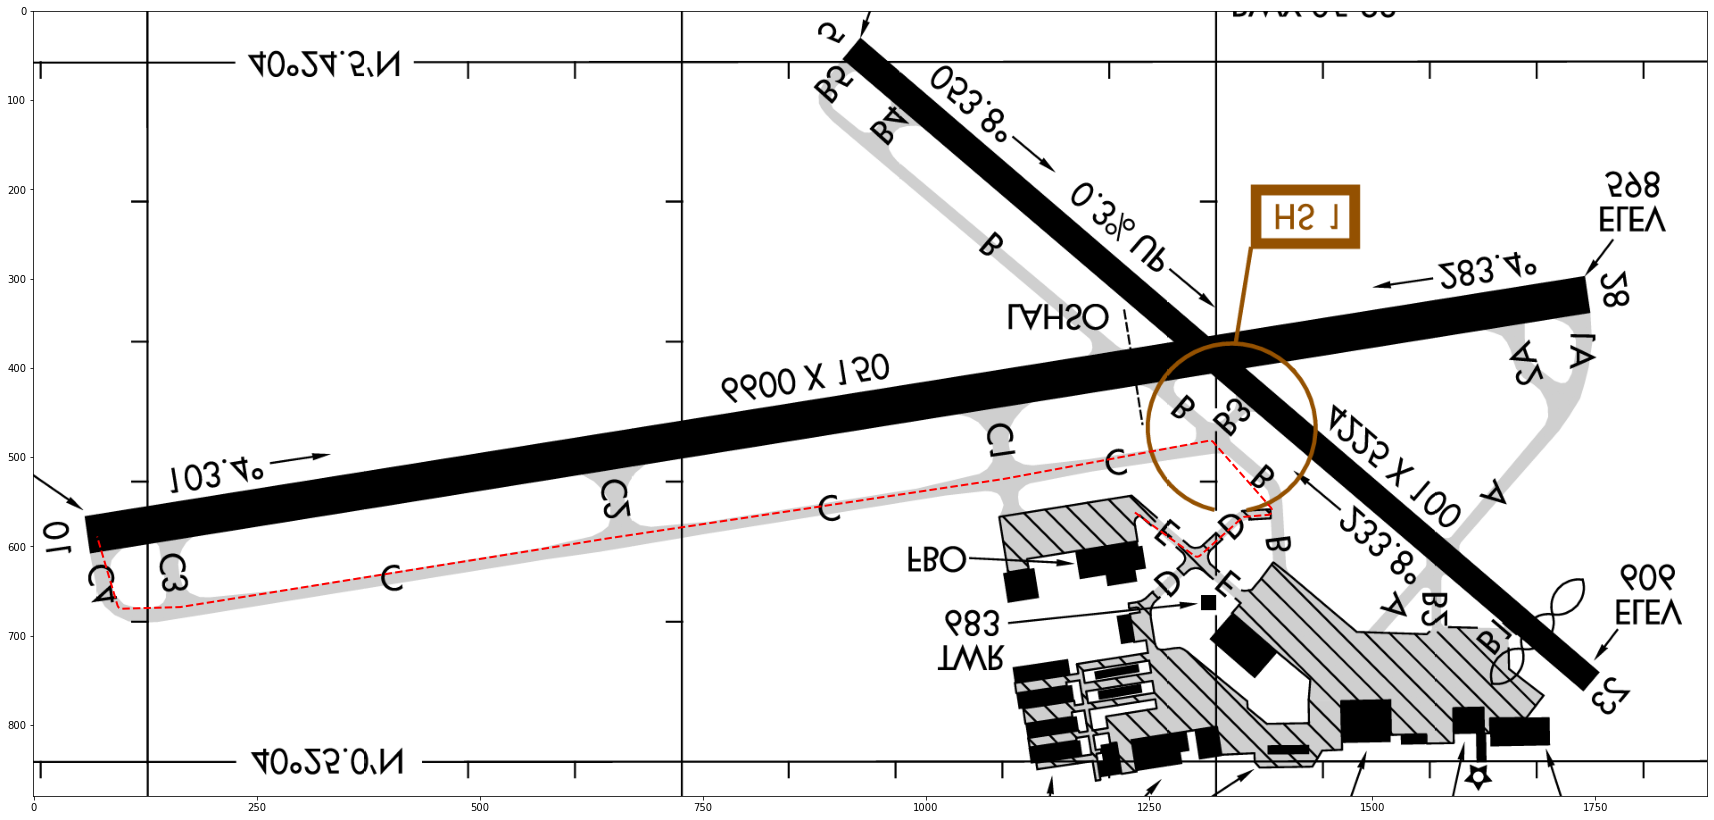

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Path_Finder import TaxiwayGraph
from util import gen_waypoints, gen_reference_trajectory


csv_file_path = r".\Position_of_Airport.csv"
image_path = 'map.png'

# Create the TaxiwayGraph object
taxiway_graph = TaxiwayGraph(csv_file_path, image_path)

# Define the start and end gates
start_gate = 'Gate 2'
end_runway = 'R10L'

# Find the shortest path from the starting gate to the runway
shortest_path_flight, control_points = taxiway_graph.find_shortest_path_flight(start_gate, end_runway)

turning_radius = 5
turning_res = 10

waypoints = gen_waypoints(control_points, turning_radius, turning_res)

desired_vel = 3
dt = .1

ref = gen_reference_trajectory(waypoints, desired_vel, dt)

print(ref[-1,-1]/60)

image_raw = mpimg.imread(image_path)  # Load the airport map image
image = np.flipud(image_raw)  

plt.figure(figsize=(30,30))
plt.plot(ref[:,0], ref[:,1], 'r--', linewidth=2)
plt.imshow(image)
plt.gca().set_aspect('equal')

Total time:  45.6388885974884
avg iteration time:  45.55311141076026 ms


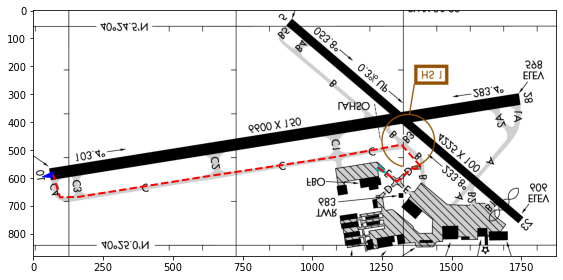

In [8]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt

mass = 1
I0 = .2

# setting matrix_weights' variables
Q_x = 1000
Q_y = 1000
Q_theta = 1000
Q_vx = 1000
Q_vy = 1000
Q_omega = 1000

R1 = 1000
R2 = 1000

step_horizon = dt  # time between steps in seconds
N = 60              # number of look ahead steps

# sim_time = 20      # simulation time

# specs
x_init = ref[0,0]
y_init = ref[0,1]
theta_init = np.arctan2(ref[1, 1] - y_init, ref[1,0] - x_init)
vx_init = 0
vy_init = 0
omega_init = 0

v_target = desired_vel

F_max = 4
F_min = -4

tau_max = 10
tau_min = -10


def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0

def DM2Arr(dm):
    return np.array(dm.full())

x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')
vx = ca.SX.sym('vx')
vy = ca.SX.sym('vy')
omega = ca.SX.sym('omega')

states = ca.vertcat(x, y, theta, vx, vy, omega)
n_states = states.numel()

force = ca.SX.sym('force')
tau = ca.SX.sym('tau')

controls = ca.vertcat(force, tau)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and reference trajectory
P = ca.SX.sym('P', n_states + N*n_states)

# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = ca.diagcat(Q_x, Q_y, Q_theta, Q_vx, Q_vy, Q_omega)

# controls weights matrix
R = ca.diagcat(R1, R2)

rot = ca.vertcat(
    ca.horzcat(0,  0),
    ca.horzcat(0,  0),
    ca.horzcat(0,  0),
    ca.horzcat(cos(theta)/mass, 0),
    ca.horzcat(sin(theta)/mass,  0),
    ca.horzcat(0,  1/I0)
)

drift = ca.vertcat(vx, vy, omega, 0, 0, 0)

RHS = drift + rot @ controls

f = ca.Function('f', [states, controls], [RHS])

cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation


# runge kutta
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[(k+1)*n_states:(k+2)*n_states]).T @ Q @ (st - P[(k+1)*n_states:(k+2)*n_states]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound
lbx[3: n_states*(N+1): n_states] = -10     # VX lower bound
lbx[4: n_states*(N+1): n_states] = -10     # VY lower bound
lbx[5: n_states*(N+1): n_states] = -.5     # omega lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound
ubx[3: n_states*(N+1): n_states] = 10     # VX upper bound
ubx[4: n_states*(N+1): n_states] = 10      # VY upper bound
ubx[5: n_states*(N+1): n_states] = .5      # omega upper bound

lbx[n_states*(N+1)::2] = F_min                 # force lower bound
lbx[n_states*(N+1)+1::2] = tau_min             # tau lower bound 

ubx[n_states*(N+1)::2] = F_max                  # v upper bound for all V
ubx[n_states*(N+1)+1::2] = tau_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0

state_init = ca.DM([x_init, y_init, theta_init, vx_init, vy_init, omega_init])        # initial state

# xx = DM(state_init)
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])


###############################################################################

if __name__ == '__main__':
    main_loop = time()  # return time in sec
    for k in range(len(ref[:1000])):
        t1 = time()
        
        p_arg_vec = ca.vertcat(state_init)
        for l in range(N):
            if k+l < len(ref):
                ref_state = ref[k+l, :2]
                if l == 0:
                    target_theta = np.arctan2(ref_state[1] - state_init[1], ref_state[0] - state_init[0])
                else:
                    target_theta = np.arctan2(ref_state[1] - ref[k+l-1,1], ref_state[0] - ref[k+l-1,0])
                v_command = v_target 
            else:
                ref_state = ref[-1, :2]
                target_theta = np.arctan2(ref_state[1] - ref[-2,1], ref_state[0] - ref[-2,0])
                v_command = 0
            
            target_state = ca.DM([ref_state[0], ref_state[1], target_theta, v_command*np.cos(target_theta), v_command*np.sin(target_theta), 0])
            
            p_arg_vec = ca.vertcat(p_arg_vec, target_state)
        
        args['p'] = p_arg_vec

        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)
        cat_states = np.dstack((
            cat_states,
            DM2Arr(X0)
        ))
        # print('u',u[:, 0])
        cat_controls = np.vstack((
            cat_controls,
            DM2Arr(u[:, 0])
        ))
        t = np.vstack((
            t,
            t0
        ))

        t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

        # print(X0)
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )

        # xx ...
        t2 = time()
        # print(mpc_iter)
        # print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1

    main_loop_time = time()

    # print('\n\n')
    print('Total time: ', main_loop_time - main_loop)
    print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')

    # simulate
    x_target, y_target = ref[-1, 0], ref[-1, 1]
    theta_target = target_theta
    simulate(ref, cat_states, cat_controls, times, step_horizon, N,
             np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), image_path, save=True)

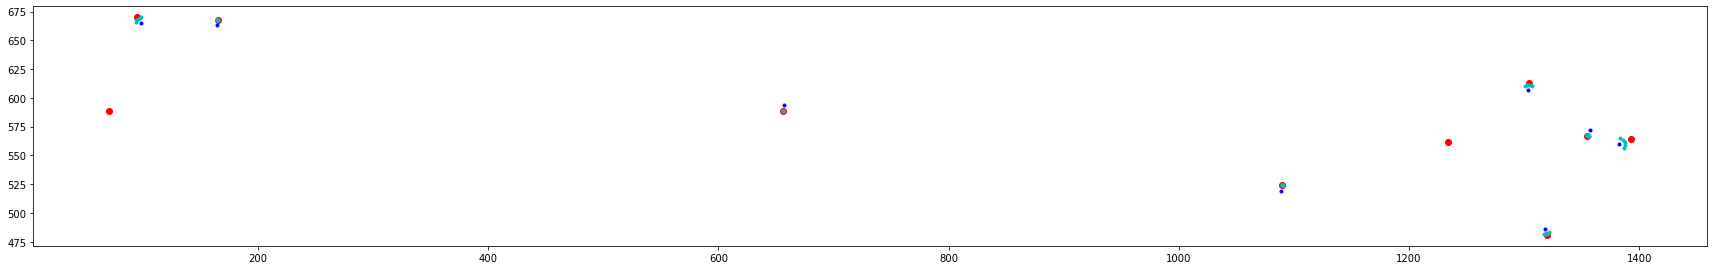

In [47]:
import numpy as np

def parametric_circle(t,c,r):
    xc, yc = c
    x = xc + r*np.cos(t)
    y = yc + r*np.sin(t)
    return x, y

def inv_parametric_circle(p,c,r):
    x, y = p
    xc, yc = c
    if y - yc >= 0 and x - xc >= 0:
        t = np.arccos((x-xc)/r)
    
    elif y - yc >= 0 and x - xc < 0:
        t = np.arccos((x-xc)/r)
    
    elif y - yc < 0 and x - xc >= 0:
        t = np.arcsin((y-yc)/r)

    elif y - yc < 0 and x - xc < 0:
        t = -np.arccos((x-xc)/r)

    return t

def gen_arc(numpoints, c, r, start, end):
    start_t = inv_parametric_circle(start, c, r)
    end_t   = inv_parametric_circle(end, c, r)

    arc_T = np.linspace(start_t, end_t, numpoints)
    X,Y = parametric_circle(arc_T, c, r)

    return X, Y

def gen_curve_points(p1, p2, p3, r, numpoints):
    a = p2-p1 
    b = p2-p3 
    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))
    theta = np.arccos(np.dot(a,b)/(a_norm*b_norm))

    d = r/np.tan(theta/2) # distance away from turn to start
    h = r/np.sin(theta/2) # distance from intersection to centerpoint of rotation
    
    sign = np.sign(np.cross(a,b)) # sign of rotation direction, clockwise if negative
    rot = np.array([[np.cos(sign*theta/2), -np.sin(sign*theta/2)],
                    [np.sin(sign*theta/2),  np.cos(sign*theta/2)]])
    
    d_a = d*(a/a_norm)
    d_b = d*(b/b_norm)

    start = p2-d_a
    end = p2-d_b

    c = p2 - h*rot@(a/a_norm)
    
    X, Y = gen_arc(numpoints, c, r, start, end)

    return start, end, c, X, Y

def gen_waypoints(control_points, r, num_turn_points):
    waypoints = [control_points[0]]
    for i in range(1, len(control_points)-1):
        p1, p2, p3 = np.array(control_points[i-1]), np.array(control_points[i]), np.array(control_points[i+1])

        start, end, c, X, Y = gen_curve_points(p1,p2,p3, r, numpoints=num_turn_points)
        for x, y in zip(X, Y):
            waypoints.append((x,y))

    waypoints.append(control_points[-1])

    return waypoints
 

import matplotlib.pyplot as plt

points_arr = np.array(control_points)

plt.figure(figsize=(30,30))
plt.plot(points_arr[:,0], points_arr[:,1], 'ro')
plt.gca().set_aspect('equal')

waypoints = [control_points[0]]
for i in range(1, len(control_points)-1):
    p1, p2, p3 = np.array(control_points[i-1]), np.array(control_points[i]), np.array(control_points[i+1])

    start, end, c, X, Y = gen_curve_points(p1,p2,p3,r=5, numpoints=5)
    for x, y in zip(X, Y):
        waypoints.append((x,y))
    plt.plot(c[0],c[1], 'b.')
    plt.plot(X, Y, 'c.')
    
waypoints.append(control_points[-1])
# plt.xlim(1200, 1410)
# plt.ylim(475, 620)
plt.show()

(475.0, 620.0)

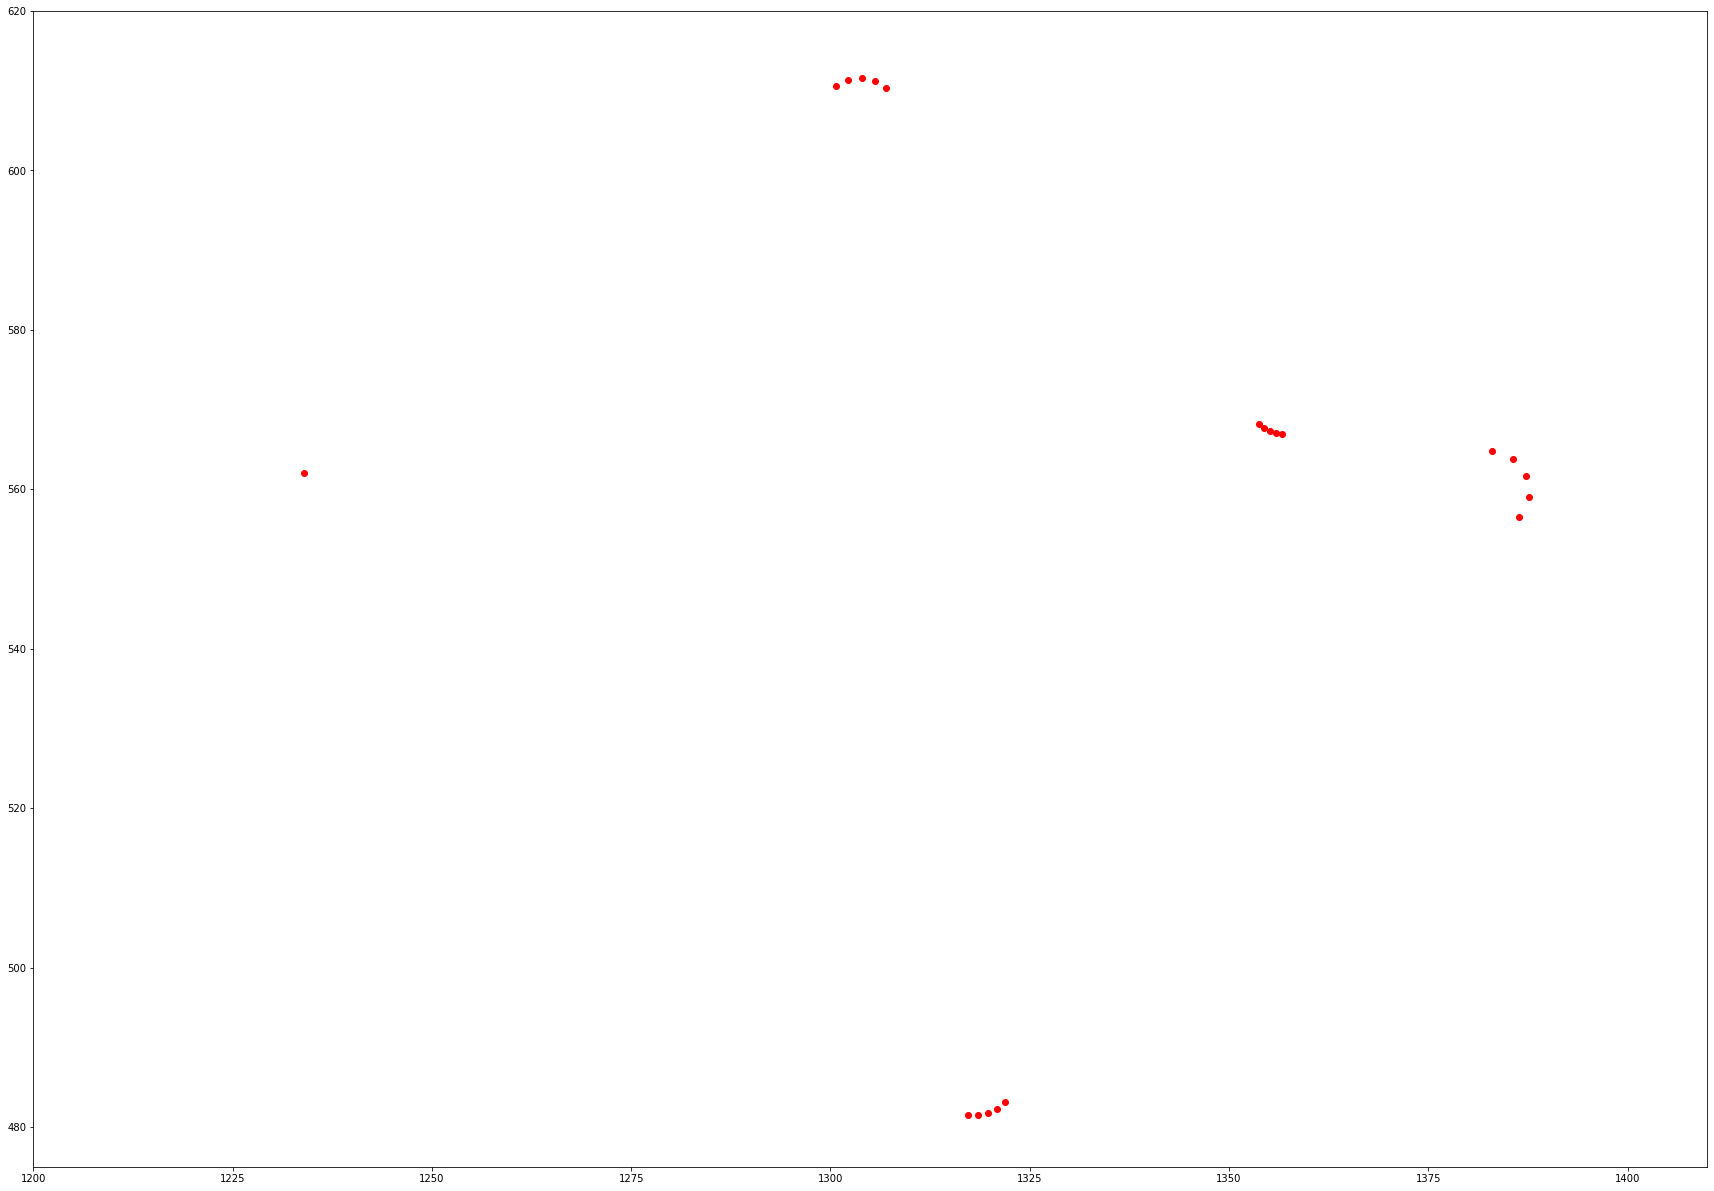

In [48]:
r = 5
numpoints = 5
wp = gen_waypoints(control_points,r,numpoints)
wp_arr = np.array(wp)

plt.figure(figsize=(30,30))
plt.plot(wp_arr[:,0],wp_arr[:,1], 'ro')
plt.gca().set_aspect('equal')

plt.xlim(1200, 1410)
plt.ylim(475, 620)